In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ginaroberg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ginaroberg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Perform the data exploration step (i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, plot example classes of the image, size of images, are sizes uniform? Do they need to be cropped? normalized? etc.
Plot your data. For tabular data, you will need to run scatters, for image data, you will need to plot your example classes.
How will you preprocess your data? You should explain this in your readme.md file and link your jupyter notebook to it. Your jupyter notebook should be uploaded to your repo.
Jupyter Notebook data download and environment setup requirements: 


In [105]:
df = pd.read_csv('Glassdoor_Job_Postings.csv')
df.head(5)

,company,job_title,company_rating,job_description,location,salary_avg_estimate,salary_estimate_payperiod,company_size,company_founded,employment_type,industry,sector,revenue,career_opportunities_rating,comp_and_benefits_rating,culture_and_values_rating,senior_management_rating,work_life_balance_rating
0,ABB,Junior Data Analyst,4.0,Junior Data Analyst\nTake your next career ste...,Bengaluru,"₹3,25,236",/yr (est.),10000+ Employees,1883,Company - Public,Electronics Manufacturing,Manufacturing,$10+ billion (USD),3.7,3.6,4.0,3.5,3.9
1,Philips,Data Scientist - AI/ML,4.0,Job Title\nData Scientist - AI/ML\nJob Descrip...,Bengaluru,NaN,NaN,10000+ Employees,1891,Company - Public,Healthcare Services & Hospitals,Healthcare,$10+ billion (USD),3.8,3.7,4.0,3.5,4.0
2,HSBC,Data Science GSC’s,3.9,Job description\nGraduate/ Post-graduate degre...,Bengaluru,NaN,NaN,10000+ Employees,1865,Company - Public,Banking & Lending,Finance,$10+ billion (USD),3.6,3.6,3.8,3.4,3.7
3,Facctum Solutions,Data Analyst,NaN,Job Description\nExperience: 0 - 2 years in da...,Karnataka,NaN,NaN,1 to 50 Employees,--,Company - Private,--,--,Unknown / Non-Applicable,NaN,NaN,NaN,NaN,NaN
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.0,JOB DESCRIPTION\n\nYou are a strategic thinker...,India,NaN,NaN,10000+ Employees,1799,Company - Public,Banking & Lending,Finance,$10+ billion (USD),4.0,3.9,3.9,3.6,3.7


## Data Preprocessing

In [106]:
# Convert company_founded to int
df['company_founded'] = df['company_founded'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)

In [107]:
# Convert salary_avg_estimate to float
df['salary_avg_estimate'] = df['salary_avg_estimate'].apply(lambda x: float(str(x).replace('₹', '').replace(',', '')) if pd.notna(x) else np.nan)

In [108]:
# Convert job_description to list
df['job_description'] = df['job_description'].apply(lambda x: x.split('\n') if pd.notna(x) else x)

In [109]:
# Create salary_avg_per_year

# Convert salary_estimate_payperiod to factors 

factors = {'/yr (est.)': 1,
          '/mo (est.)': 12,
          '/hr (est.)': 2123}

df['salary_estimate_payperiod'] = df['salary_estimate_payperiod'].apply(lambda x: factors[x] if (type(x) == str) else x)

# Multiply 'salary_avg_estimate' by 'salary_estimate_payperiod'
df['salary_avg_estimate'] = df['salary_avg_estimate'] * df['salary_estimate_payperiod']

# Rename the column to 'salary_avg_estimate_per_year'
df = df.rename(columns={'salary_avg_estimate': 'salary_avg_estimate_per_year'})
df.drop(columns = 'salary_estimate_payperiod')

,company,job_title,company_rating,job_description,location,salary_avg_estimate_per_year,company_size,company_founded,employment_type,industry,sector,revenue,career_opportunities_rating,comp_and_benefits_rating,culture_and_values_rating,senior_management_rating,work_life_balance_rating
0,ABB,Junior Data Analyst,4.0,"[Junior Data Analyst, Take your next career st...",Bengaluru,325236.0,10000+ Employees,1883.0,Company - Public,Electronics Manufacturing,Manufacturing,$10+ billion (USD),3.7,3.6,4.0,3.5,3.9
1,Philips,Data Scientist - AI/ML,4.0,"[Job Title, Data Scientist - AI/ML, Job Descri...",Bengaluru,NaN,10000+ Employees,1891.0,Company - Public,Healthcare Services & Hospitals,Healthcare,$10+ billion (USD),3.8,3.7,4.0,3.5,4.0
2,HSBC,Data Science GSC’s,3.9,"[Job description, Graduate/ Post-graduate degr...",Bengaluru,NaN,10000+ Employees,1865.0,Company - Public,Banking & Lending,Finance,$10+ billion (USD),3.6,3.6,3.8,3.4,3.7
3,Facctum Solutions,Data Analyst,NaN,"[Job Description, Experience: 0 - 2 years in d...",Karnataka,NaN,1 to 50 Employees,NaN,Company - Private,--,--,Unknown / Non-Applicable,NaN,NaN,NaN,NaN,NaN
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.0,"[JOB DESCRIPTION, , You are a strategic thinke...",India,NaN,10000+ Employees,1799.0,Company - Public,Banking & Lending,Finance,$10+ billion (USD),4.0,3.9,3.9,3.6,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,Kpro Solutions,Analytics & Data Science,4.0,"[Experience & Qualification:, , Minimum of 9 y...",Bengaluru,483915.0,1 to 50 Employees,NaN,Company - Private,--,--,Unknown / Non-Applicable,4.0,4.0,4.0,4.0,4.0
896,Athena Global Technologies,Data Engineer,NaN,"[Immediate requirement for Data Engineer, Expe...",Hyderābād,678949.0,51 to 200 Employees,NaN,Company - Private,--,--,Unknown / Non-Applicable,4.2,3.5,4.0,3.9,3.9
897,Wesco,India-Bangalore: Data Engineer,3.7,[This person will work independently or with a...,Bengaluru,651920.0,10000+ Employees,1922.0,Company - Public,Wholesale,Retail & Wholesale,$10+ billion (USD),3.5,3.4,3.6,3.3,3.8
898,Course5,Data Scientist,4.2,[If you meet our position requirements and can...,Bengaluru,424426.0,1001 to 5000 Employees,2000.0,Company - Private,Business Consulting,Management & Consulting,$100 to $500 million (USD),4.3,4.1,4.3,4.1,4.2


In [110]:
#one hot encode company size
one_hot_encoder = OneHotEncoder(sparse=False)

# Fit and transform the data
encoded_data = one_hot_encoder.fit_transform(df[['company_size']])

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(['company_size']))

# Concatenate with the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

#one hot encode revenue

# Fit and transform the data
encoded_data = one_hot_encoder.fit_transform(df[['revenue']])

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(['revenue']))

# Concatenate with the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

#one hot encode sector
one_hot_encoder = OneHotEncoder(sparse=False)

encoded_data = one_hot_encoder.fit_transform(df[['sector']])

encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(['sector']))

df = pd.concat([df, encoded_df], axis=1)

df.head(5)

,company,job_title,company_rating,job_description,location,salary_avg_estimate_per_year,salary_estimate_payperiod,company_size,company_founded,employment_type,...,sector_Management & Consulting,sector_Manufacturing,sector_Media & Communication,sector_Non-profit & NGO,sector_Pharmaceutical & Biotechnology,sector_Real Estate,sector_Retail & Wholesale,sector_Telecommunications,sector_Transportation & Logistics,sector_nan
0,ABB,Junior Data Analyst,4.0,"[Junior Data Analyst, Take your next career st...",Bengaluru,325236.0,1.0,10000+ Employees,1883.0,Company - Public,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Philips,Data Scientist - AI/ML,4.0,"[Job Title, Data Scientist - AI/ML, Job Descri...",Bengaluru,NaN,NaN,10000+ Employees,1891.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HSBC,Data Science GSC’s,3.9,"[Job description, Graduate/ Post-graduate degr...",Bengaluru,NaN,NaN,10000+ Employees,1865.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Facctum Solutions,Data Analyst,NaN,"[Job Description, Experience: 0 - 2 years in d...",Karnataka,NaN,NaN,1 to 50 Employees,NaN,Company - Private,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.0,"[JOB DESCRIPTION, , You are a strategic thinke...",India,NaN,NaN,10000+ Employees,1799.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
# Concatenate text
def tokenize(job_description):
    def is_iterable(obj):
        try:
            iter(obj)
            return True
        except TypeError:
            return False
        if not is_iterable(job_description):
            return None

# Check if job_description is not iterable or is empty
    if not is_iterable(job_description) or len(job_description) == 0:
        return None

    text = ''.join(job_description)

    # Lowercase conversion
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)

    # Removing punctuation and special characters
    tokens = [re.sub(r'[^a-zA-Z0-9\s]', '', token) for token in tokens if token.isalnum()]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Feature extraction (optional)
    # This can involve extracting skills, qualifications, responsibilities, etc. based on patterns in the text.
    return tokens

df['job_description'] = df['job_description'].apply(tokenize)
df.dropna(subset=['job_description'], inplace=True)
df['job_description'] = df['job_description'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'job_description' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['job_description'])

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame for visualization (optional)
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

df = pd.concat([df, df_tfidf], axis=1)

# Print the concatenated DataFrame
numeric_columns = [col for col in df.columns if re.match(r'^\d', col)]
df = df.drop(columns=numeric_columns)

In [112]:
df

,company,job_title,company_rating,job_description,location,salary_avg_estimate_per_year,salary_estimate_payperiod,company_size,company_founded,employment_type,...,zonesexcellent,zonesgood,zoneswilling,zookeeper,zoom,zoominfo,zs,zsers,zycus,zydus
0,ABB,Junior Data Analyst,4.0,junior data analysttake next career step abb g...,Bengaluru,325236.0,1.0,10000+ Employees,1883.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Philips,Data Scientist - AI/ML,4.0,job titledata scientist descriptionjob title d...,Bengaluru,NaN,NaN,10000+ Employees,1891.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HSBC,Data Science GSC’s,3.9,job degree relevant field data science certifi...,Bengaluru,NaN,NaN,10000+ Employees,1865.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Facctum Solutions,Data Analyst,NaN,job descriptionexperience 0 2 years data opera...,Karnataka,NaN,NaN,1 to 50 Employees,NaN,Company - Private,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.0,job descriptionyou strategic thinker passionat...,India,NaN,NaN,10000+ Employees,1799.0,Company - Public,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Exploration

## Plots

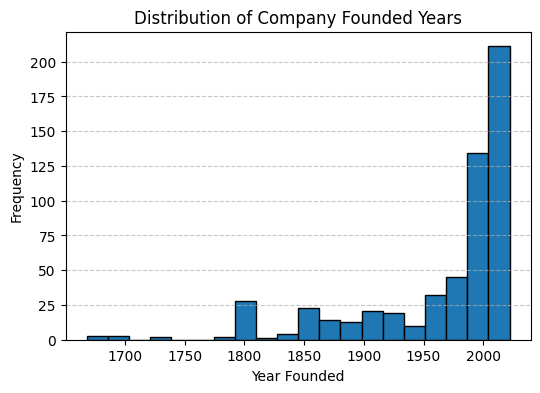

In [113]:
plt.figure(figsize=(6, 4))
plt.hist(df['company_founded'], bins=20, edgecolor='black')
plt.xlabel('Year Founded')
plt.ylabel('Frequency')
plt.title('Distribution of Company Founded Years')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [114]:
df['avg_rating'] = (df['career_opportunities_rating']+df['comp_and_benefits_rating']+ df['culture_and_values_rating']+df['senior_management_rating']+ df['work_life_balance_rating'])/5
df['avg_rating']

0      3.74
1      3.80
2      3.62
3       NaN
4      3.82
       ... 
675     NaN
773     NaN
810     NaN
811     NaN
861     NaN
Name: avg_rating, Length: 900, dtype: float64

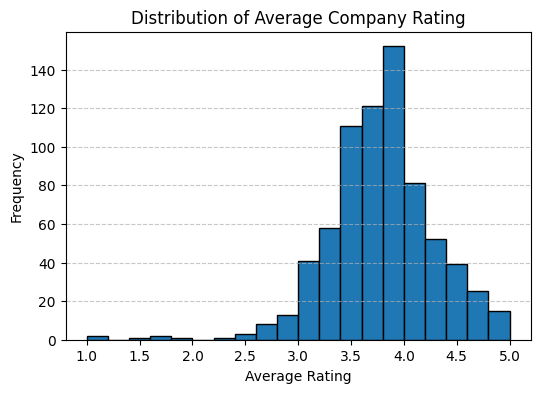

In [115]:
plt.figure(figsize=(6, 4))
plt.hist(df['avg_rating'], bins=20, edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Company Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

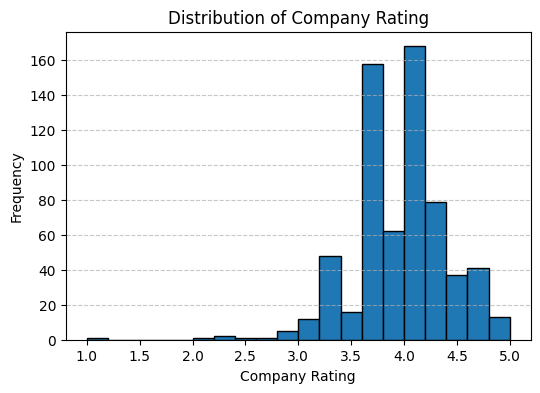

In [116]:
plt.figure(figsize=(6, 4))
plt.hist(df['company_rating'], bins=20, edgecolor='black')
plt.xlabel('Company Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Company Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

/var/folders/n6/mdk2dy5d57z2whgw3t4yhpth0000gn/T/ipykernel_39158/2456740748.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='employment_type', data=df, palette='viridis')


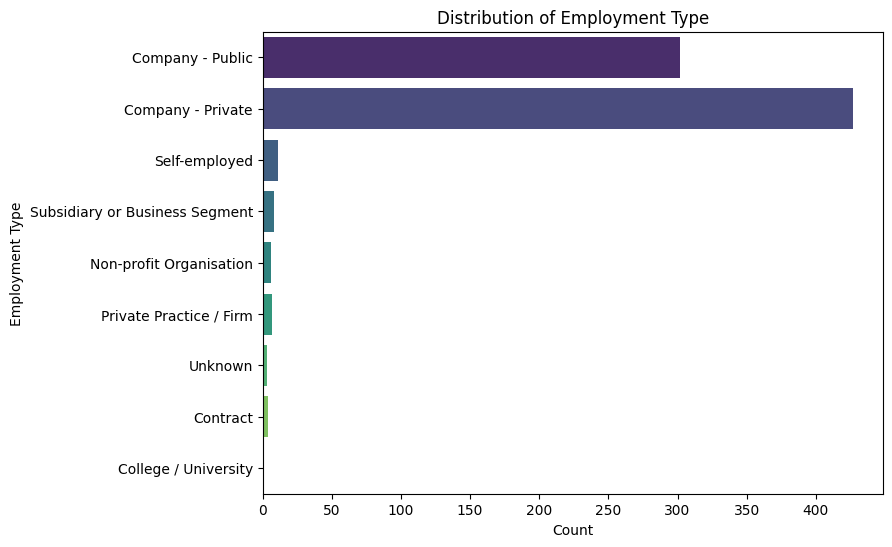

In [117]:
plt.figure(figsize=(8, 6))
sns.countplot(y='employment_type', data=df, palette='viridis')
plt.title('Distribution of Employment Type')
plt.xlabel('Count')
plt.ylabel('Employment Type')
plt.show()

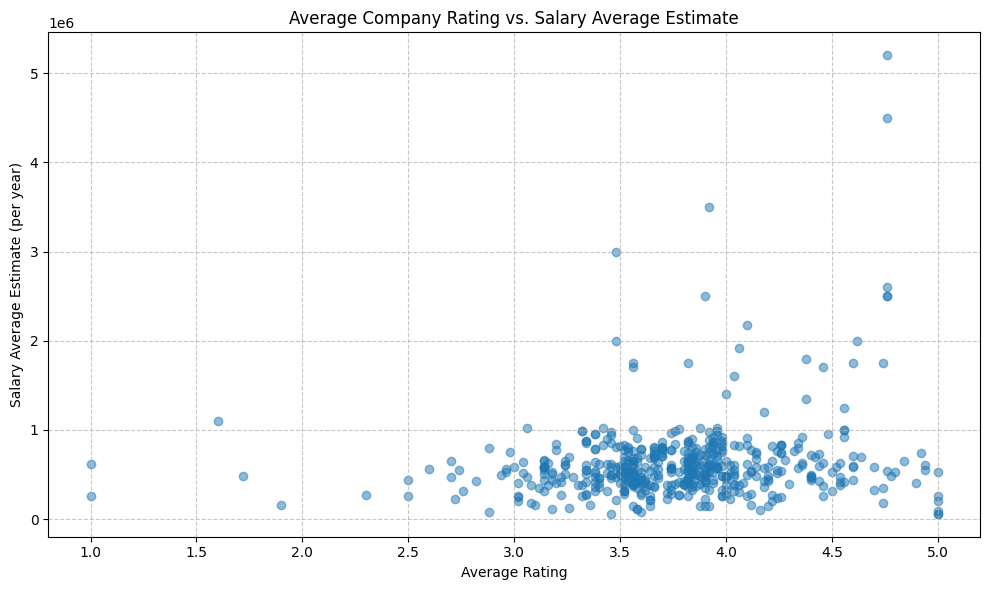

In [120]:
plt.figure(figsize=(10, 6))
plt.scatter(df['avg_rating'], df['salary_avg_estimate_per_year'], alpha=0.5)
plt.xlabel('Average Rating')
plt.ylabel('Salary Average Estimate (per year)')
plt.title('Average Company Rating vs. Salary Average Estimate')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/n6/mdk2dy5d57z2whgw3t4yhpth0000gn/T/ipykernel_39158/2036315882.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='salary_avg_estimate_per_year', y='Sector', data=melted_data, palette='viridis')


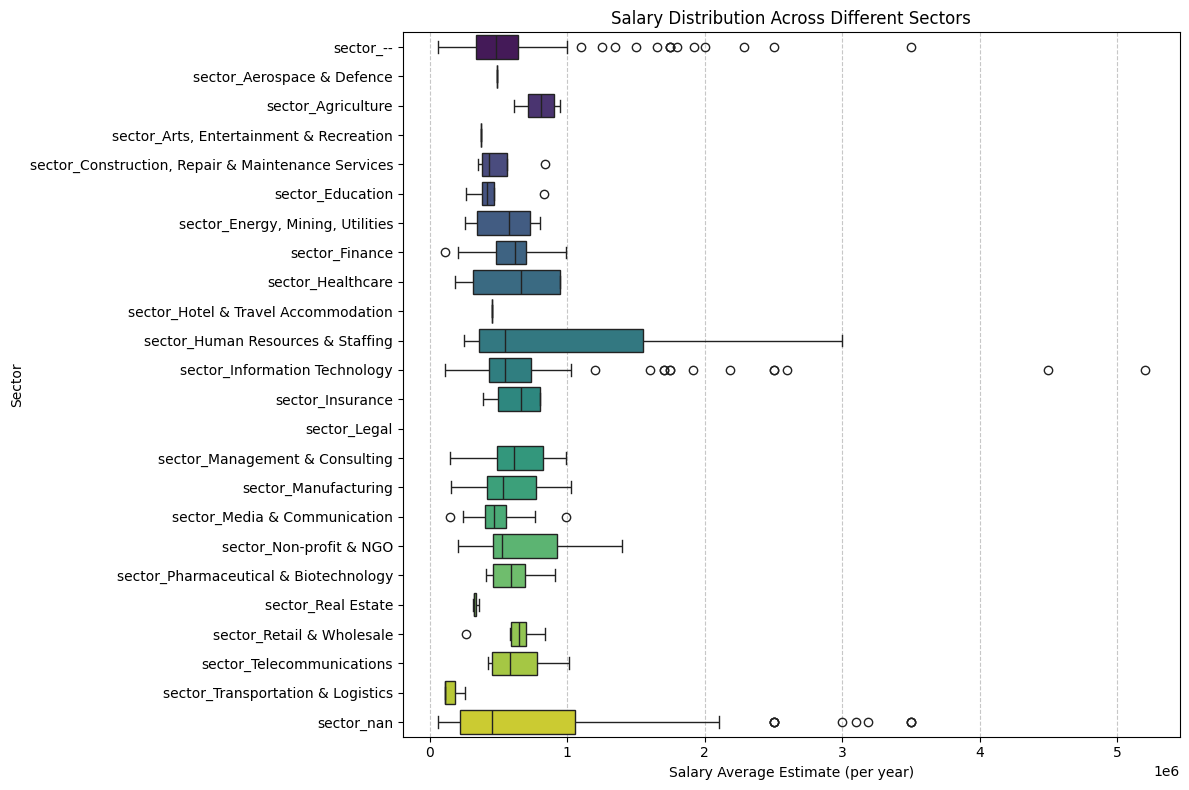

In [121]:
sector_columns = [col for col in df.columns if col.startswith('sector_')]
data = df[['salary_avg_estimate_per_year'] + sector_columns]

melted_data = data.melt(id_vars='salary_avg_estimate_per_year', var_name='Sector', value_name='Sector_Encoded')
melted_data = melted_data[melted_data['Sector_Encoded'] == 1]

plt.figure(figsize=(12, 8))
sns.boxplot(x='salary_avg_estimate_per_year', y='Sector', data=melted_data, palette='viridis')
plt.xlabel('Salary Average Estimate (per year)')
plt.ylabel('Sector')
plt.title('Salary Distribution Across Different Sectors')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()